In [1]:


import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *



processGens=ProcessGens()

#wmt modes
process_gen_modes=["wmt_samples0", "only_qwen_8b"]


#5 threads for llama1, 

processGens.init_with_mode(process_gen_modes)
root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric = processGens.get_params()
compare_metric="example_comet"
examples_df, completions_df=get_dfs(processGens)

examples_df["rank"]=100-examples_df["example_idx"]
completions_df["rank"]=100-completions_df["example_idx"]


dfs_by_model={}
for model_name in examples_df['model'].unique():
    filtered_df = examples_df[examples_df["model"]==model_name]
    
    dfs_by_model[model_name]=filtered_df


all_dfs_by_model=dfs_by_model
df=next(iter(dfs_by_model.values()))

/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.


Init: process_gens_mode ['wmt_samples0', 'only_qwen_8b']
calculate_gen_summary_dict
snellius_copies/helm_output/sample_100_eval_1000/wmt_14_language_pair_de_en_/meta_llama_Llama_3.1_8B_Instruct/1_beams/runs/sample_100_eval_1000
get_metrics_dict
calculate_gen_summary_dict
snellius_copies/helm_output/sample_100_eval_500_first_inst_0/wmt_14_language_pair_de_en_/Qwen_Qwen3_8B/1_beams/runs/sample_100_eval_500_first_inst_0
get_metrics_dict
Index(['example_comet', 'beam_num', 'task_name', 'model', 'example_idx',
       'suite', 'instanceID', 'text', 'completion_length', 'output_logprob',
       'isCompletion'],
      dtype='object')
Num examples: 150000
Num completions: 1500


/var/folders/w4/6m47nb7x1cv2hsxbb89dmcz80000gn/T/ipykernel_88644/1159941081.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completions_df["rank"]=100-completions_df["example_idx"]


In [2]:
print(f"\t root_folder: {root_folder} \n \t num_beams_list {num_beams_list} \n \t models: {models} \n \t custom_metrics{[metric.name() for metric in custom_metrics]}"+ 
    f"\n \t task_names {task_names} \n \t suite_name {suite_name} \n \t instance_metrics {instance_metrics}")
# instanceGeneration=get_first(processGens.first_run_instances)
print(examples_df.head(2))
print("num examples" ,len(examples_df))
print("num_completions", len(completions_df))
print(f"compare_metric mean: ",examples_df[[compare_metric]].mean())
#current belief: for each run_folder combo, there will be 100 instances and 100 examples per instance

	 root_folder: snellius_copies/helm_output 
 	 num_beams_list [1] 
 	 models: ['Qwen/Qwen3-8B'] 
 	 custom_metrics[]
 	 task_names ['wmt_14_language_pair_de_en_'] 
 	 suite_name sample_100_eval_500_first_inst_0 
 	 instance_metrics ['comet']


   example_comet  beam_num                    task_name  \
0       0.865341         1  wmt_14_language_pair_de_en_   
1       0.861965         1  wmt_14_language_pair_de_en_   

                              model  example_idx                 suite  \
0  meta_llama_Llama_3.1_8B_Instruct            0  sample_100_eval_1000   
1  meta_llama_Llama_3.1_8B_Instruct            1  sample_100_eval_1000   

   instanceID                                               text  \
0           0  He advised the parents of a boy whose penis ha...   
1           0  He advised the parents of a boy whose penis wa...   

   completion_length  output_logprob isCompletion  rank  
0                178       -8.308031         True   100  
1                177       -8.531994         None    99  
num examples 150000
num_completions 1500
compare_metric mean:  example_comet    0.774351
dtype: float64


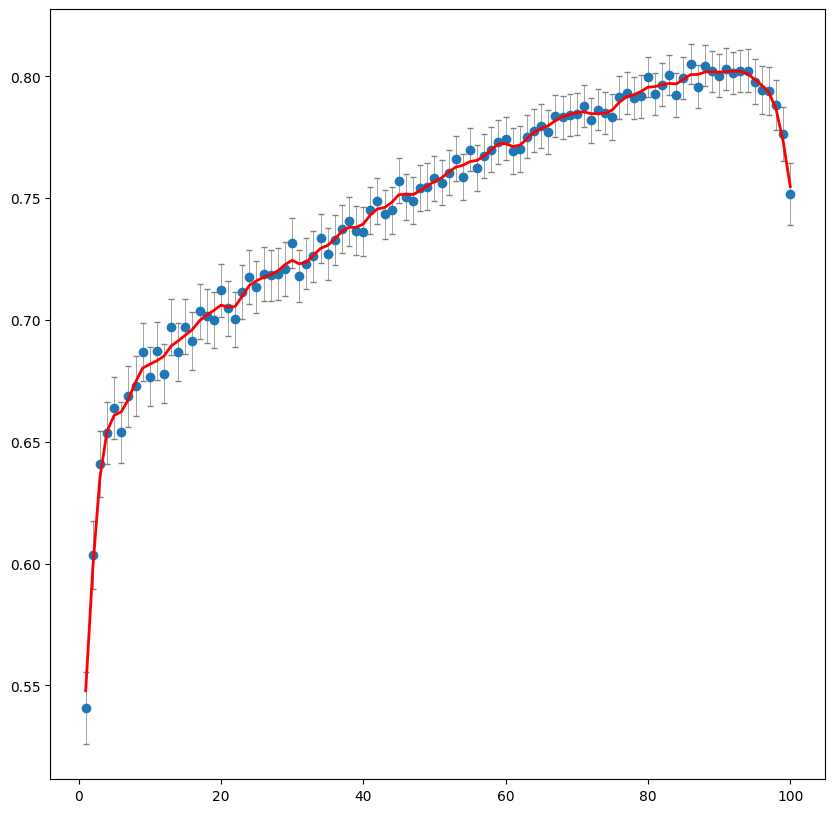

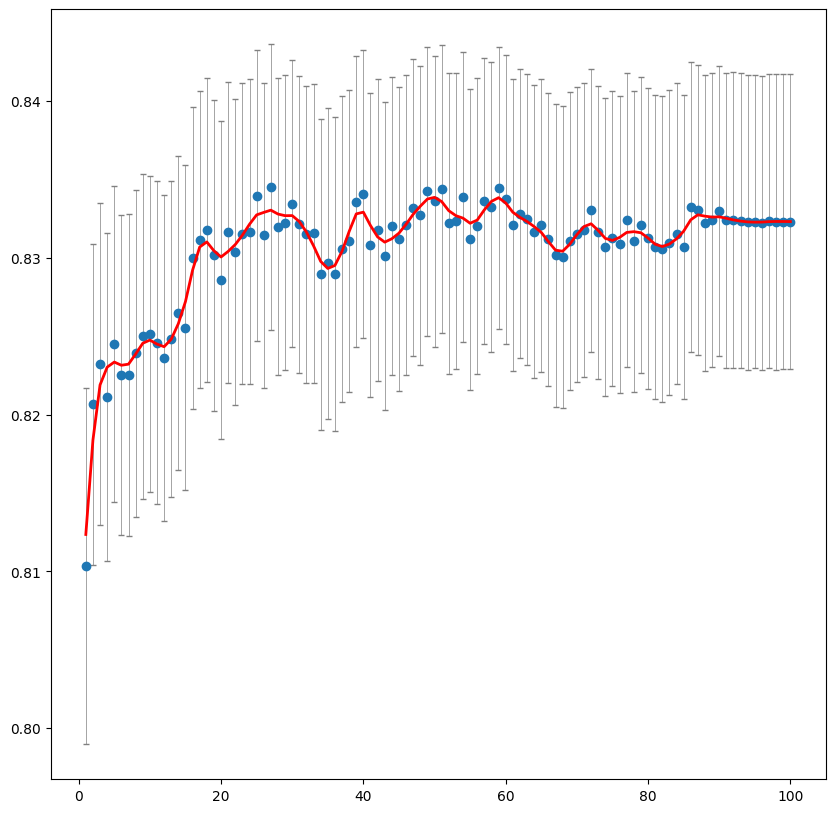

In [7]:
from scipy.interpolate import make_smoothing_spline
def plot_smooth_spline(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=False):
    if(ax is None):
        _, ax = plt.subplots(figsize=(10, 10))
    warnings.simplefilter(action='ignore', category=FutureWarning)

    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])    
    grouped = grouped.sort_values(by=(xlabel, 'mean'))

    x = grouped[(xlabel, 'mean')].values
    y = grouped[(ylabel, 'mean')].values
    

    yerr = grouped[(ylabel, 'std')].values
    yerr=[]
    for i in grouped.index:
        # print(grouped.loc[i][ylabel])
        _, c, s = grouped.loc[i][ylabel]
        yerr.append(1.96*s/math.sqrt(c))



    if(error_bar):
        ax.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=2, elinewidth=0.5, label='Data with std dev', zorder=00)
    else:
        ax.scatter(x,y)
    spl = make_smoothing_spline(x, y)
    ax.plot(x, spl(x), '-',linewidth=2, color="red", zorder=10)



for idx, (model_name, filtered_df) in enumerate(dfs_by_model.items()):
    plot_smooth_spline(df=filtered_df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title="", error_bar=True)

In [4]:
#first: I calculate win rates

def get_iom_metrics_dict(df,compare_metric,ax=None):
    # plot_grouped(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20):
    # grouped = df.groupby("example_idx")[[xlabel, ylabel]].agg(['mean', 'count', 'std'])

    max_example_idx = df["example_idx"].max()
    num_ranks=max_example_idx+1
    # pivoted = df.pivot(columns='example_idx', values=compare_metric )
    # pivoted_mean=pivoted.mean()
    pivoted = df.pivot(index="instanceID",columns="example_idx", values=compare_metric )
    # print(pivoted.head(2))
    mean_pivoted=pivoted.mean()
    ave_val=mean_pivoted.mean()

    # pivoted_x = df.pivot(columns="example_idx", values="output_logprob").mean()
    
    best_rank = mean_pivoted.idxmax()
    ranks_effected=best_rank
    percent_effected=ranks_effected / num_ranks
    score_diff=0

    win_rate_by_col=[-1]*(best_rank+1)
    for compare_rank in range(best_rank+1):
        win_rate_col_name=f"win_rate_{compare_rank}"
        pivoted[win_rate_col_name] = pivoted.apply( lambda row: get_win_rate(row,compare_rank, best_rank) , axis=1)
        win_rate_by_col[compare_rank] = pivoted[win_rate_col_name].mean()

    win_rate=win_rate_by_col[0]
    # print("win_rate_by_col",win_rate_by_col)

    for compare_rank in range(best_rank):
        score_diff+= mean_pivoted[best_rank]-mean_pivoted[compare_rank]
    

    effect_size=score_diff*percent_effected
    average_diff=score_diff/ranks_effected
    effect_diff=mean_pivoted[best_rank]-mean_pivoted[0]

    average_diff_norm=average_diff/ave_val
    effect_diff_norm=effect_diff/ave_val
    effect_size_norm=effect_size /ave_val

    return {
        # "effect_size": effect_size,
        # "average_diff": average_diff,
        # "effect_diff": effect_diff,
        "percent_effected":percent_effected,
        "win_rate":win_rate,

        "average_diff_norm":average_diff_norm,
        "effect_diff_norm":effect_diff_norm,
        "effect_size_norm":effect_size_norm
    }



iom_metrics_dict_by_model={}
for idx, (model_name, filtered_df) in enumerate(dfs_by_model.items()):
    # print(model_name)
    iom_metrics_dict_by_model[model_name]=get_iom_metrics_dict(filtered_df, compare_metric=compare_metric)
    print(iom_metrics_dict_by_model[model_name])




# 14% effected, 






    


{'percent_effected': np.float64(0.14), 'win_rate': np.float64(0.5205), 'average_diff_norm': np.float64(0.015042813671901004), 'effect_diff_norm': np.float64(0.07155627229668524), 'effect_size_norm': np.float64(0.02948391479692597)}
{'percent_effected': np.float64(0.73), 'win_rate': np.float64(0.515), 'average_diff_norm': np.float64(0.0030292415010853826), 'effect_diff_norm': np.float64(0.0026411475392891307), 'effect_size_norm': np.float64(0.16142827959284003)}


In [5]:
print(iom_metrics_dict_by_model)

{'meta_llama_Llama_3.1_8B_Instruct': {'percent_effected': np.float64(0.14), 'win_rate': np.float64(0.5205), 'average_diff_norm': np.float64(0.015042813671901004), 'effect_diff_norm': np.float64(0.07155627229668524), 'effect_size_norm': np.float64(0.02948391479692597)}, 'Qwen/Qwen3-8B': {'percent_effected': np.float64(0.73), 'win_rate': np.float64(0.515), 'average_diff_norm': np.float64(0.0030292415010853826), 'effect_diff_norm': np.float64(0.0026411475392891307), 'effect_size_norm': np.float64(0.16142827959284003)}}


In [6]:
#Here is current goal:

#each metric gets a graph
#each suite gets a line
#x axis is model size
#y axis is metric



def append_to_dict(dict, key_list, value):
    cur_key=key_list[0]
    
    #make sure it exists
    if cur_key not in dict.keys():
        dict[cur_key]={}

    #append recursively if not
    if(len(key_list)>1):
        append_to_dict(dict[cur_key], key_list[1:], value)
    else:
        dict[cur_key]=value


iom_metrics_dict_by_properties={}

for (model_name, iom_metrics_dict) in iom_metrics_dict_by_model.items():
    model_details = get_model_details(model_name)

    append_to_dict(iom_metrics_dict_by_properties, [ model_details["suite"], model_details["model_type"],  model_details["size"] ], iom_metrics_dict)

print(iom_metrics_dict_by_properties.keys())



    
print(iom_metrics_dict_by_model)
#plot by model size
# iom_metric_keys=next(iter(iom_metrics_dict_by_model.values())).keys()
# for iom_metric in iom_metric_keys: 
#     fig, ax = plt.subplots()
#     for suite in iom_metrics_dict_by_properties.keys():
#         for model_type in iom_metrics_dict_by_properties[suite].keys():
#             x=[]
#             y=[]
#             for size in iom_metrics_dict_by_properties[suite][model_type].keys():
#                 value=iom_metrics_dict_by_properties[suite][model_type][size][iom_metric]
#                 x.append(size)
#                 y.append(value)
#             ax.scatter(x,y, label=suite)
#     ax.set_xlabel('model size')
#     ax.set_ylabel(iom_metric)
#     ax.legend()
#     fig.show()

#plot by model strength
# for iom_metric in iom_metric_keys: 
#     # print("iom_metric")
#     fig, ax = plt.subplots()
#     x=[]
#     y=[]
#     for (model_name, iom_metrics_dict) in iom_metrics_dict_by_model.items():
#         filtered_df=dfs_by_model[model_name]
#         ave_vale=filtered_df[compare_metric].mean()
#         x.append(ave_vale)
#         y.append(iom_metrics_dict[iom_metric])
#     ax.scatter(x,y)
#     ax.set_xlabel("Average "+str(compare_metric))
#     ax.set_ylabel(iom_metric)
#     ax.legend()
#     #fig.show()





KeyError: 'Qwen/Qwen3-8B'

213
213
246
246


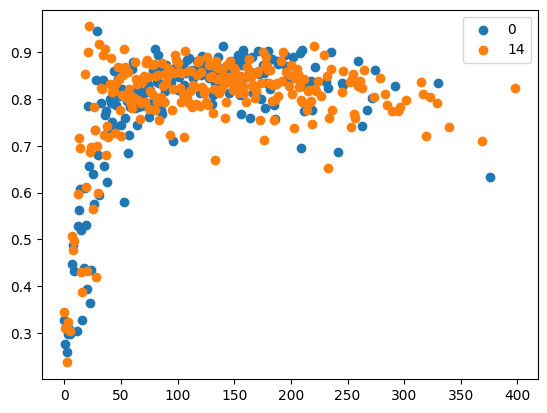

In [7]:
#ok, I only want to keep columns where the rank is 14 or 0
df = filtered_df
max_example_idx = df["example_idx"].max()
num_ranks=max_example_idx+1
pivoted = df.pivot(index="instanceID",columns="example_idx", values=compare_metric )
mean_pivoted=pivoted.mean()
ave_val=mean_pivoted.mean()
best_rank = mean_pivoted.idxmax()

best_and_first=filtered_df[ filtered_df['example_idx'].isin([0, best_rank])]

cols_to_keep=["example_comet", "example_idx", "output_logprob", "completion_length"]
best_and_first=best_and_first[["example_comet", "example_idx", "output_logprob", "completion_length"]]

best_and_first_grouped=best_and_first.groupby(["completion_length", "example_idx"]).mean().reset_index()

_, ax = plt.subplots()


# #we want to see, for each completion length, the average metric score
# #we will do this for both ranks, 0 and 14

for rank in [0, best_rank]:
    cur_df=best_and_first_grouped[best_and_first_grouped["example_idx"]==rank]
    x=cur_df["completion_length"]
    y=cur_df["example_comet"]
    print(len(x))
    print(len(y))
    ax.scatter(x,y, label=rank)
    ax.legend()




In [8]:
filtered_df["logprob_per_length"]=filtered_df["output_logprob"]/ filtered_df["completion_length"]

filtered_df['rank2'] = filtered_df.groupby('instanceID')['logprob_per_length'].rank(method='first', ascending=True) - 1
filtered_df['rank2'] = filtered_df['rank2'].astype(int)



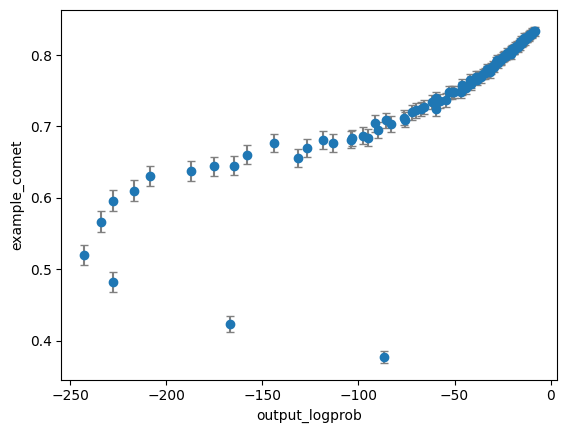

In [9]:
plot_grouped(filtered_df, "output_logprob", compare_metric, groupby='rank2', title=None, trend_line="None",ax=None)

In [12]:
#ok, we just want to predict
#example metric using length and rank

import statsmodels.api as sm
best_and_first["is_completion"]=(best_and_first["example_idx"]==0).astype(int)

X = best_and_first[['completion_length', 'is_completion']]
X = sm.add_constant(X) 
y = best_and_first['example_comet']

model = sm.OLS(y, X).fit()

print(model.summary())

#so, ideally is_completion should be negatively correlated with example_comet


                            OLS Regression Results                            
Dep. Variable:          example_comet   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     189.7
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           3.68e-76
Time:                        16:36:55   Log-Likelihood:                 848.60
No. Observations:                2000   AIC:                            -1691.
Df Residuals:                    1997   BIC:                            -1674.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.6936      0.00

In [14]:


X = filtered_df[['completion_length', 'output_logprob']]
X = sm.add_constant(X) 
y = filtered_df['example_comet']

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          example_comet   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     7937.
Date:                Thu, 19 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:43:10   Log-Likelihood:                 42406.
No. Observations:              100000   AIC:                        -8.481e+04
Df Residuals:                   99997   BIC:                        -8.478e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7243      0.00